# Bootstrap Distribution and Confidence Intervals

Alternatives to reporting $p$-values include providing a characterization of the full  distribution of the test statistic under the null hypothesis and reporting a confidence interval, which provides a range that characterizes the most likely values of the test statistic. We start with the distribution of the test statistic under the null hypothesis.

## Bootstrap Distribution

If we perform bootstrap sampling and create sample values of the test statistic, then the set of those values can be used to characterize the distribution of the test statistic.

````{card}
DEFINITION
^^^
```{glossary}
bootstrap distribution
    For some statistic of sample data, the *bootstrap distribution* is a characterization of the possible values of that statistic and the mapping of probability to those values that arises from creating values of that statistic via bootstrap sampling. Whereas the sampling distribution is based on samples from the original random distribution, the bootstrap distribution is based on resampling from a fixed set of data.
```
````
(Note that the term *distribution* is defined more precisely when we define random variables in {doc}`Chapter 8<../08-random-variables/intro>`.)
In this chapter, we will study the bootstrap distribution using histograms.  

We will revisit our test on median wealth using the NLSY79 data set to illustrate these ideas. After loading the necessary libraries and data, we will modify our previous simulation to save every sample value of the test statistic. An efficient way to do this is to create an array of zeros (to preallocate all the needed storage space) and then fill in the appropriate value of the array at each iteration of the simulation:




In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr



In [4]:
import pandas as pd
repo = 'https://raw.githubusercontent.com/jmshea/Foundations-of-Data-Science-with-Python/'
df = pd.read_csv(repo + 'main/05-binary-hypothesis-testing/nls/nls.csv')
remap = {'R0000100':'CASE_ID',
         'T5597600': 'GENDER',
         'T5684500': 'NET_WEALTH',
         'T9900000': 'HIGHEST_GRADE_EVER'
        }
df.rename(columns=remap, inplace=True)
df2 = df[(df['HIGHEST_GRADE_EVER']>0 ) & (df['NET_WEALTH']>0) ].copy()

# Filter on highest grade ever completed and then save the NET_WEALTH column into a new variable 
# (it will be a Pandas Series, which acts much like a DataFrame)
undergrad = df2.query('HIGHEST_GRADE_EVER >= 16 & HIGHEST_GRADE_EVER <=17')['NET_WEALTH']                
grad = df2.query('HIGHEST_GRADE_EVER >= 18')['NET_WEALTH']

pooled = df2.query('HIGHEST_GRADE_EVER >= 16')['NET_WEALTH']                



In [5]:
num_sims = 10_000
test_statistics = np.zeros(num_sims)

# Define these to avoid having to keep calling a function to get them in every iteration
grad_len = len(grad)
undergrad_len = len(undergrad)

for sim in range(num_sims):
  undergrad_sample = npr.choice(pooled, undergrad_len)
  grad_sample = npr.choice(pooled, grad_len)

  # Calculate the sample value of the test statistic
  sample_diff = np.median(grad_sample) - np.median(undergrad_sample)
  
  # Now we store the value of the test statistic instead of doing a one-sided test
  test_statistics[sim] = sample_diff

Given the array of test statistics, let's start by generating a histogram with 40 bins:

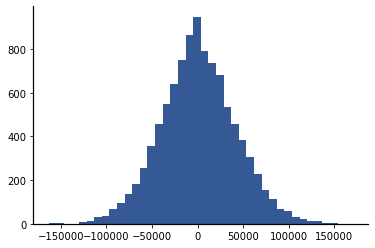

In [6]:
plt.hist(test_statistics, bins=40);

Because so many of the values are large, let's plot in thousands of dollars, which we will abbreviate $K:

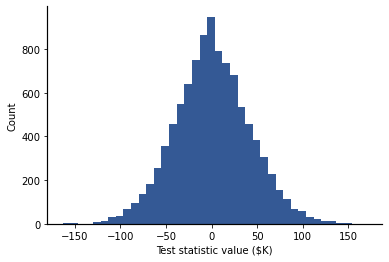

In [7]:
plt.hist(test_statistics/1000, bins=40);
plt.xlabel('Test statistic value ($K)');
plt.ylabel('Count');

This is the shape of the bootstrap distribution. We can immediately make a few observations:
* The distribution is (approximately) symmetric around zero. This should be expected, because under the null hypothesis, the two data from each group is coming from the same distribution. Thus, any differences are equally likely to be positive or negative.
* Almost all of the values are in the interval $[-150, 150]$, with the majority of the values in $[-100, 100]$.

Let's add a line to the histogram to denote the value of the test statistic that we observed in the data. We can draw a vertical line using the matplotlib function `plt.axvline()`:

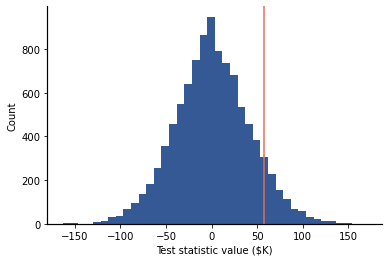

In [8]:
plt.hist(test_statistics/1000, bins=40);
plt.xlabel('Test statistic value ($K)');
plt.ylabel('Count');
# Draw a vertical line at the observed value of the test statistic
plt.axvline(57.4, color='C1');

Then the $p$-value for the one-sided test is the proportion of values in the sampling distribution that are to the right of the orange line. It is hard to infer the value of $p$ from a traditional histogram. However, we can pass a couple of keyword parameters to `plt.hist()` that will make it easier to find the $p$-value:
* `cumulative = True` will make the value accumulate from left to right, and
* `density = True` will normalize the histogram. With the `cumulative = True` option, the results is that the $y$-axis value corresponding to any point on the $x$-axis will be the proportion of values that are less than that $x$-axis value.

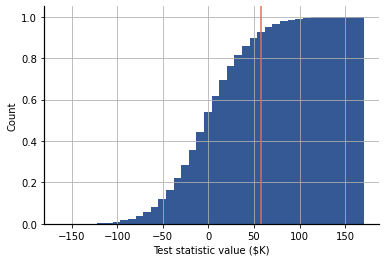

In [9]:
plt.hist(test_statistics/1000, bins=40, cumulative = True, density = True);
plt.xlabel('Test statistic value ($K)');
plt.ylabel('Count');
# Draw a vertical line at the observed value of the test statistic
plt.axvline(57.4, color='C1');
plt.grid();

If we zoom in to the upper right quadrant, we will see the following:

(0.5, 1.0)

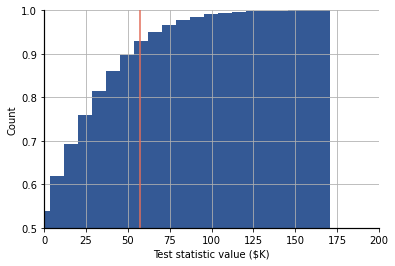

In [10]:
plt.hist(test_statistics/1000, bins=40, cumulative = True, density = True);
plt.xlabel('Test statistic value ($K)');
plt.ylabel('Count');
# Draw a vertical line at the observed value of the test statistic
plt.axvline(57.4, color='C1');
plt.grid();
plt.xlim(0,200);
plt.ylim(0.5, 1)

The proportion less than 57,400 is approximately 0.92, which means that the probability of the test statistic being greater than 57,400 under the null hypothesis is approximately 0.08. 

We will revisit the bootstrap distribution again in {doc}`Chapter 9<../intro>` when we have the tools we need to better understand random distributions and their characterization.

## Confidence Intervals 

Confidence intervals provide a method of summarizing information about the distribution of the test statistic under the null hypothesis in a way that is different than $p$-values. Confidence intervals are often suggested as a better alternative over $p$-values. However, we will see that they are actually very similar to $p$-values and, like $p$-values, are often subject to misinterpretation. In this section, I define confidence intervals, show different ways to calculate confidence intervals, and discuss their interpretation.  We begin with a definition:

````{card}
DEFINITION
^^^
```{glossary}
confidence interval (CI)
    Given samples from a random distribution and a confidence level c%, the c% CI for some parameter is an interval that will contain the true value of the parameter c% of the time if the sampling process were repeated many times.
```
````

A typical confidence level is 95%, and we will use that value in this section.

For the purposes of this chapter, the observed value of the test statistic is the parameter of interest. We construct a confidence interval under the null hypothesis, and we can assign statistical significance to the result if it does **not** belong to the confidence interval for the null hypothesis. If the data came from the null hypothesis, then the observed value will not lie within the confidence interval  95% of the time data like this is drawn from the underlying distribution.

A common *misinterpretation* is that given a particular c% confidence interval is that it has a c% chance of containing the true parameter value. This is incorrect because c% refers to the proportion of *different* confidence intervals that will contain the true parameter value.  Thus, the c% confidence level is a measure of how reliable the confidence interval estimation process is, not how reliable a particular confidence interval is.


There are different ways to generate confidence intervals depending on the application. In the case of null hypothesis testing, the distribution of the test statistic is centered around zero. This knowledge allows us to create a c% confidence interval by finding the interval that contains c% of the bootstrapped test statistic values. (This method is sometimes called the *percentile method*, and may not be safe to apply directly in other applications.)

It is easiest to understand creating confidence intervals using the percentile method from the normalized cumulative histogram. For a 95% confidence interval, we wish to find the interval that excludes 2.5% of the data in the left tail and 2.5% of the data in the right tail. The left threshold is where the normalized cumulative histogram takes on the value 0.025, and the right threshold is  where that histogram takes on the value $1-0.025 =0.975$. These thresholds are shown as lines in the figure below:

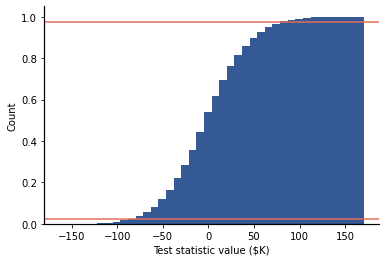

In [11]:
plt.hist(test_statistics/1000, bins=40, cumulative = True, density = True);
plt.xlabel('Test statistic value ($K)');
plt.ylabel('Count');
import matplotlib.pyplot as plt
plt.axhline(y=0.025, color='C1', linestyle='-')
plt.axhline(y=0.975, color='C1', linestyle='-');

By looking at where the horizontal lines intersect the surface of the histogram, we can estimate that the 95% confidence interval is approximately $[-75, 70]$. We can zoom in on each of these regions to get a better estimate:

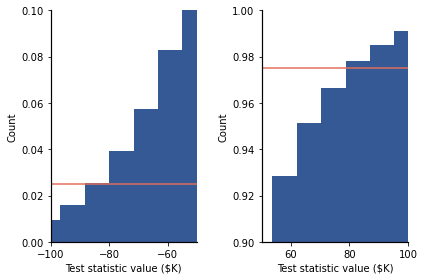

In [12]:
xlims = [(-100, -50), (50, 100)]
ylims = [(0, 0.1), (0.9, 1)]

fig, axes = plt.subplots(1,2)
for i, axis in enumerate(axes):
  axis.hist(test_statistics/1000, bins=40, cumulative = True, density = True);
  axis.set_xlabel('Test statistic value ($K)');
  axis.set_ylabel('Count');
  axis.axhline(y=0.025, color='C1', linestyle='-')
  axis.axhline(y=0.975, color='C1', linestyle='-');
  axis.set_xlim(xlims[i]);
  axis.set_ylim(ylims[i]);
  
plt.tight_layout()

With the zoomed in values, we can see that the confidence interval is approximately $[-85, 82]$.  Since the confidence interval contains the observed value of the test statistic, ($57,400), the result is not statistically significant.

Using the graphs is intuitive but also error-prone, and its resolution is limited by the number of bins used in the histogram. Fortunately, we can find these thresholds in a very simple way. We will just find the values that are 2.5% of the way through the sorted data and 97.5% of the way through the sorted data. These are called the 2.5% and 97.5% *percentiles*, and NumPy has a `np.percentile()` function that will return the values without us having to sort the data and choose the appropriate indices. We can use it to find these percentiles by passing it the array of values and a list of the desired percentiles:

In [13]:
#CI = np.quantile(test_statistics, [2.5/100, 97.5/100])
CI = np.percentile(test_statistics, [2.5, 97.5])


print(f'The 95% CI is {np.round(CI/1000,1)} in $K')

The 95% CI is [-80.8  84.5] in $K


Again, the 95% CI under the null hypothesis contains the observed value of the decision statistic, so the result is not statistically significant. 

```{note}

The percentiles are closely related to quantiles. For data, the quantiles give the value that is a certain proportion of the way through the data. Thus, the 2.5 percentile value is the same as the 0.025 quantile.
```

```{warning}

**Small Data Warning**

Confidence intervals created using the bootstrap with small data may be too narrow. For instance, 
Hesterberg indicates that for highly skewed data that bootstrapping may be worse than more conventional approaches when the number of samples is less than or equal to 34.[^Hesterberg]

[^Hesterberg]: Hesterberg, Tim C. “What Teachers Should Know About the Bootstrap: Resampling in the Undergraduate Statistics Curriculum.” The American statistician vol. 69,4 (2015): 371-386. 